# Multidimensional double-well model

In [15]:
from DoubleWell import *

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [3]:
import torch
import bgflow as bg
ctx = {'dtype': torch.float32, 'device': torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')}
ctx

{'dtype': torch.float32, 'device': device(type='cuda', index=0)}

## get MD samples
To save time we run MD with the highest dimension, then we can mask the data to do the experiment at any lower dim using the same MD data

In [5]:
base_dim = 2**6
T_low = 1 / kB
T_high = 5 / kB

modelMD = DoubleWellOpenMM(ModifiedWolfeQuapp(base_dim))

modelMD.dim, modelMD.MD_dim

(64, 66)

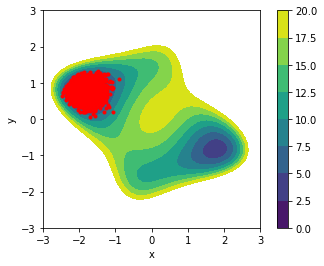

CPU times: user 27.2 s, sys: 3.29 s, total: 30.5 s
Wall time: 25 s


In [6]:
%%time
#sample target

pace = 100
n_iter = 10_000
n_equil = 100

integrator = openmm.LangevinMiddleIntegrator(T_low*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

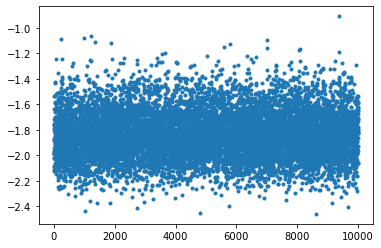

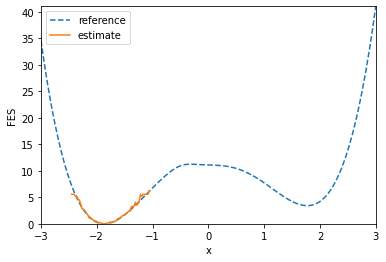

ref DeltaF: 3.31506 [kBT]
    DeltaF: inf [kBT]


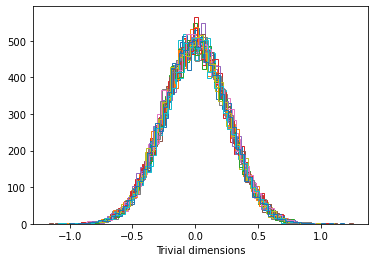

In [7]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], T_low)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.xlabel('Trivial dimensions')
plt.show()

In [8]:
target_data = torch.as_tensor(data.reshape(len(data),-1)[:,:base_dim], **ctx)
target_data.shape

torch.Size([10000, 64])

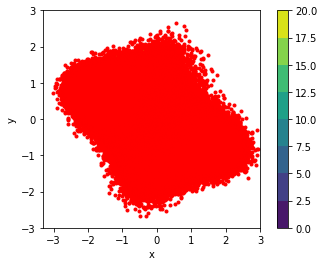

CPU times: user 3min 5s, sys: 19.2 s, total: 3min 24s
Wall time: 2min 58s


In [9]:
%%time
#sample prior

# pace = 100
len_training = 5*100*2**7
n_iter = len_training + 10_000

integrator = openmm.LangevinMiddleIntegrator(T_high*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate
simulation.step(pace*n_equil)

#run MD
data = np.full((n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
    print(f'sampling...  {n/n_iter:.1%}', end='\r')

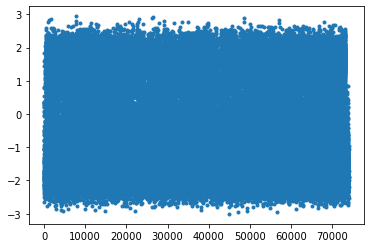

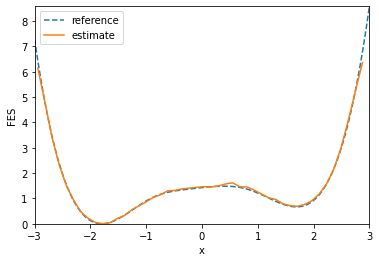

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.53709 [kBT]


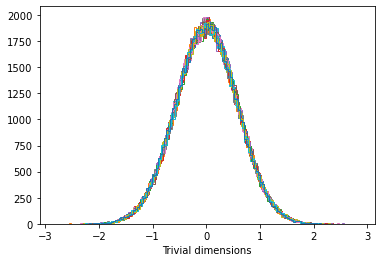

In [10]:
plt.plot(data[:,0,0], '.')
plt.show()
plot_fes(data[:,0,0], T_high)

plt.hist(data[:,0,2], bins='auto', histtype='step')
for j in range(min(10, (base_dim-1)//3)):
    for i in range(3):
        plt.hist(data[:,1+j,i], bins='auto', histtype='step')
plt.xlabel('Trivial dimensions')
plt.show()

In [11]:
prior_data = torch.as_tensor(data.reshape(len(data),-1)[:len_training,:base_dim], **ctx)
testing_data = torch.as_tensor(data.reshape(len(data),-1)[len_training:,:base_dim], **ctx)
prior_data.shape, testing_data.shape

(torch.Size([64000, 64]), torch.Size([10000, 64]))

## setup the flow

In [20]:
dim = base_dim
store_energies = False

assert dim <= base_dim, 'run MD with larger base_dim'

model = ModifiedWolfeQuapp(dim)
target = ModifiedWolfeQuapp(dim, beta=1/(T_low*kB)).to(**ctx)
prior = bg.CustomDistribution(
    ModifiedWolfeQuapp(dim, beta=1/(T_high*kB)).to(**ctx), 
    bg.DataSetSampler(prior_data[:,:dim], shuffle=True, **ctx)
)
xy_grid, priorMask = get_xy_grid(dim, prior, ctx)

print(f'N = {dim}')

N = 64


In [21]:
#setup the flow
n_coupling = 1
n_splitting = 2
zero_init = True
hidden_nodes = [2**7, 2**7]

assert dim % n_splitting == 0, 'change the splitting scheme to use this dim'
nodes = [dim-dim//n_splitting, *hidden_nodes, dim//n_splitting]
splitting = [dim//n_splitting] * n_splitting
layers = [bg.SplitFlow(*splitting)]
for _ in range(n_coupling):
    for i in range(n_splitting):
        transformer = bg.AffineTransformer(
            shift_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU()),
            scale_transformation=bg.DenseNet(nodes, activation=torch.nn.ReLU())
        )
        layers.append(bg.CouplingFlow(transformer, transformed_indices=[i], cond_indices=[j for j in range(n_splitting) if j != i]))
layers.append(bg.MergeFlow(*splitting))
flow = bg.SequentialFlow(layers).to(**ctx)
generator = bg.BoltzmannGenerator(prior, flow, target)

tot_param = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Number of Parameters: {tot_param:_}")

if zero_init:
    for p in flow.parameters():
        p.data.fill_(0)
with torch.no_grad():
    print(f'Delta max: {(xy_grid - flow(xy_grid)[0]).abs().max().item():g}')
    print(f'dlogp max: {flow(xy_grid)[1].abs().max().item():g}')

Number of Parameters: 99_458
Delta max: 0
dlogp max: 0


In [22]:
#setup training
batchsize = 2**7
w_likelihood = 0

optimizer = torch.optim.Adam(generator.parameters(), lr=1e-2)
trainer = bg.KLTrainer(generator, optimizer)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1/10, verbose=True)
prior._delegate_sampler.reshuffle_()
if w_likelihood == 0:
    print('energy training only')

Adjusting learning rate of group 0 to 1.0000e-02.
energy training only


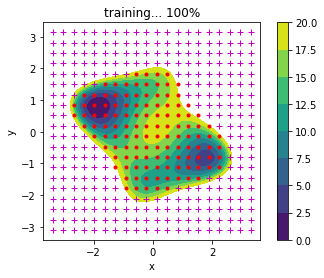

CPU times: user 29.1 s, sys: 7.98 s, total: 37 s
Wall time: 21.8 s


In [24]:
%%time
with torch.no_grad():
    mapped_xy = flow(xy_grid)[0]
    plot_doublewell(mapped_xy[priorMask], mapped_xy[~priorMask])

stride = 5
n_iter = 100
#run energy training
for i in range(n_iter):
    if i % (n_iter//4) == 0 and i != 0:
        scheduler.step()
    trainer.train(stride, target_data[:,:dim], batchsize=batchsize, w_likelihood=w_likelihood)
    clear_output(wait=True)
    plt.title(f'training... {(i+1)/(n_iter):.0%}')
    with torch.no_grad():
        mapped_xy = flow(xy_grid)[0]
        plot_doublewell(mapped_xy[priorMask], mapped_xy[~priorMask])

KLD from 163.916 to 89.0129
NLL from 6.50856 to -19.0878


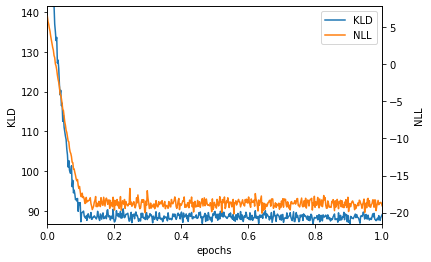

In [38]:
plot_training(trainer.reporter, len_training/batchsize/len(trainer.reporter._raw[0]))

## visualize results

PRIOR
Sampling efficiency: 0.01%
ESS: 1.00475


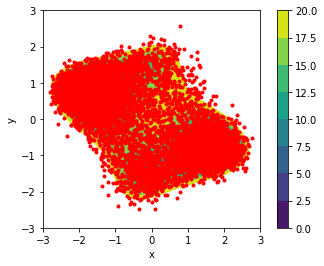

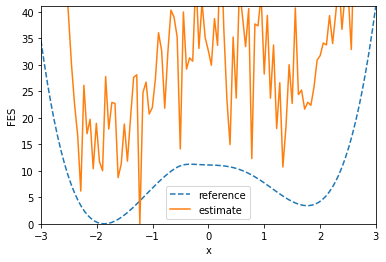

ref DeltaF: 3.31506 [kBT]
    DeltaF: 10.5163 [kBT]

BOLTZMANN GENERATOR
Sampling efficiency: 21.56%
ESS: 2156.36


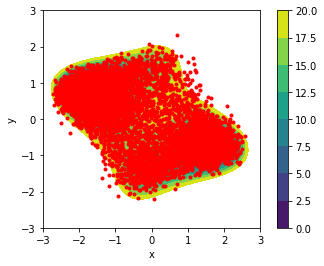

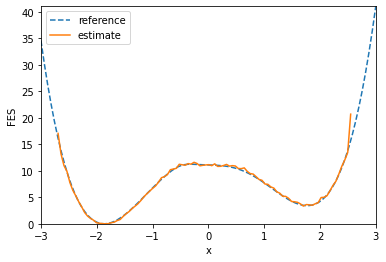

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.47066 [kBT]


In [26]:
# n_samples = len(testing_data)
prior._delegate_sampler.reshuffle_()
with torch.no_grad():
    print('PRIOR')
    # samples = torch.cat((prior_data, testing_data))[:,:dim]
    prior_samples = testing_data[:,:dim]
    prior_ene = prior.energy(prior_samples)
    logw = prior_ene - target.energy(prior_samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(prior_samples)
    plot_fes(prior_samples[:,0].cpu(), T_low, w=logw.exp().view(-1).cpu(), bins=100)
    
    print('\nBOLTZMANN GENERATOR')
    # samples, logw = generator.sample(n_samples, with_log_weights=True)
    mapped_samples, dlogp = flow(prior_samples)
    logw = prior_ene + dlogp - target.energy(mapped_samples)
    logw -= logw.max()
    print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')
    print(f'ESS: {bg.effective_sample_size(logw).item():g}')
    plot_doublewell(mapped_samples)
    plot_fes(mapped_samples[:,0].cpu(), T_low, w=logw.exp().view(-1).cpu(), bins=100)

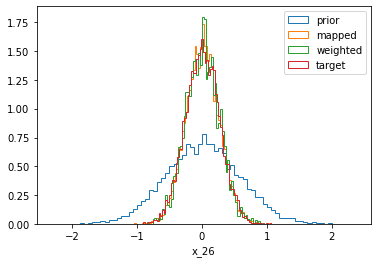

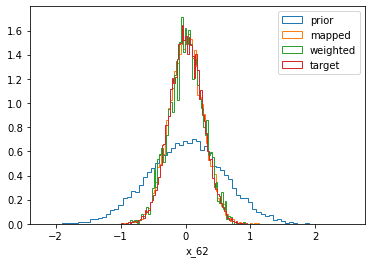

In [27]:
#1D marginal
hist_opt = {'bins': 75, 'histtype': 'step', 'density': True}
for i in [np.random.randint(0, dim), np.random.randint(0, dim)]:
    plt.hist(prior_samples[:,i].cpu(), **hist_opt, label='prior')
    plt.hist(mapped_samples[:,i].cpu(), **hist_opt, label='mapped')
    plt.hist(mapped_samples[:,i].cpu(), **hist_opt, weights=logw.exp().view(-1).cpu(), label='weighted')
    plt.hist(target_data[:,i].cpu(), **hist_opt, label='target')
    plt.xlabel(f'x_{1+i}')
    plt.legend()
    plt.show()

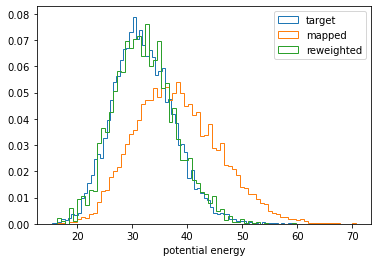

In [41]:
#energy
hist_opt = {'bins': 75, 'histtype': 'step', 'density': True}
plt.hist(target.energy(target_data[:,:dim]).view(-1).cpu(), **hist_opt, label='target')
# plt.hist(target.energy(prior_samples).view(-1).cpu(), **hist_opt, label='prior')
plt.hist(target.energy(mapped_samples).view(-1).cpu(), **hist_opt, label='mapped')
plt.hist(target.energy(mapped_samples).view(-1).cpu(), weights=logw.exp().view(-1).cpu(), **hist_opt, label='reweighted')
plt.xlabel('potential energy')
plt.legend()
plt.show()

#store them
energies = [target.energy(target_data[:,:dim]).view(-1).cpu().numpy(), 
            target.energy(mapped_samples).view(-1).cpu().numpy(), 
            target.energy(prior_samples).view(-1).cpu().numpy()
           ]
# np.save(f'DoubleWell{dim}-NFenergies.pny', energies)

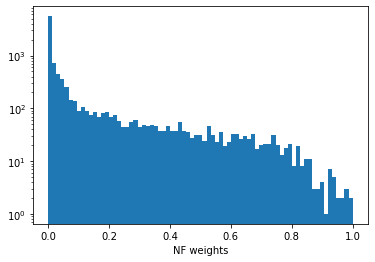

Sampling efficiency: 21.56%


In [39]:
#weights
plt.hist(logw.exp().view(-1).cpu().numpy(), bins=75)
plt.yscale('log')
plt.xlabel('NF weights')
plt.show()
print(f'Sampling efficiency: {bg.sampling_efficiency(logw).item():.2%}')

## run LREX

In [30]:
%%time

pace = 100
n_iter = 10_000
mc_stride = 1

n_replicas = 2
temperatures = [T_low, T_high]
modelMD = DoubleWellOpenMM(model)
initial_pos = [modelMD.positions] * n_replicas
integrator = []
simulation = []
for i in range(n_replicas):
    integrator.append(openmm.LangevinMiddleIntegrator(temperatures[i]*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond))
    simulation.append(openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[i]))
    simulation[i].context.setPositions(initial_pos[i])

n_equil = 100
for i in range(n_replicas):
    print('equilibrating...', i, end='\r')
    simulation[i].step(n_equil*pace)

CPU times: user 265 ms, sys: 109 ms, total: 374 ms
Wall time: 397 ms


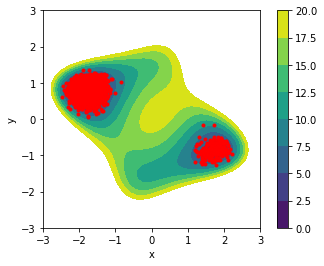

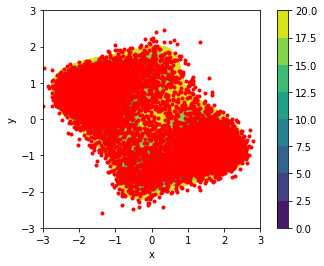

CPU times: user 1min 45s, sys: 7.77 s, total: 1min 53s
Wall time: 1min 42s


In [31]:
%%time

data = np.full((n_replicas, n_iter, *modelMD.positions.shape), np.nan)
is_swapped = np.full(n_iter, False)
for n in range(n_iter):
    for i in range(n_replicas):
        simulation[i].step(pace)
        data[i][n] = simulation[i].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometer)
    if n % mc_stride == 0:           
        with torch.no_grad():
            z_h = torch.as_tensor(data[1][n], **ctx).view(1, modelMD.MD_dim)[:,:dim]
            x_h, dlogp_h = flow(z_h, inverse=False)
            logw_h = prior.energy(z_h) + dlogp_h - target.energy(x_h)

            x_l = torch.as_tensor(data[0][n], **ctx).view(1, modelMD.MD_dim)[:,:dim]
            z_l, dlogp_l = flow(x_l, inverse=True)
            logw_l = target.energy(x_l) + dlogp_l - prior.energy(z_l)
        
        delta_energy = -(logw_h + logw_l).item()
        if delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy):
            is_swapped[n] = True
            simulation[0].context.setPositions(np.resize(x_h.cpu().numpy(), modelMD.positions.shape))
            simulation[0].context.setVelocitiesToTemperature(temperatures[0])
            simulation[1].context.setPositions(np.resize(z_l.cpu().numpy(), modelMD.positions.shape))
            simulation[1].context.setVelocitiesToTemperature(temperatures[1])
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[0,:n+1,:])
        plot_doublewell(data[1,:n+1,:])
    print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {mc_stride*is_swapped[:n+1].sum()/(n+1):.2%}', end='\r')

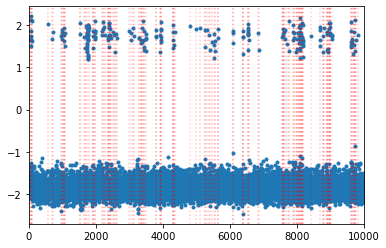

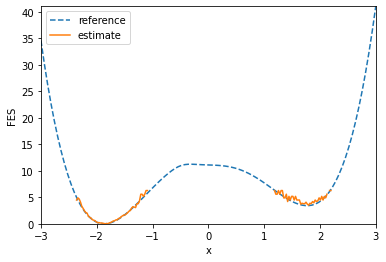

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.6718 [kBT]


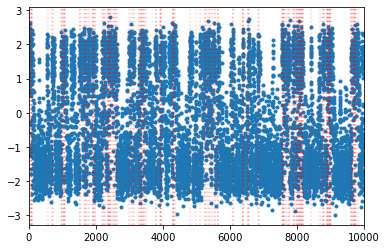

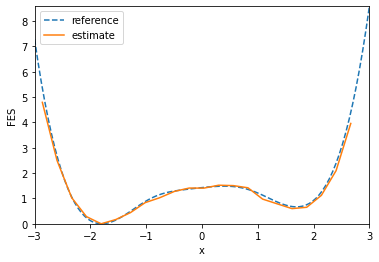

ref DeltaF: 0.52824 [kBT]
    DeltaF: 0.416728 [kBT]


In [32]:
diff = np.array(data[0, :, 0, 0]*data[1, :, 0, 0] < 0)
for i in range(n_replicas):
    plt.plot(data[i, :, 0, 0], ".")
    for sw in np.where(is_swapped)[0]:
        if diff[sw]: #highlight only useful exchanges
            plt.axvline(sw, c='r', ls=':', alpha=.1)
    plt.xlim(0, n_iter)
    plt.show()
    plot_fes(data[i, :, 0, 0], temperatures[i])
    plt.show()

Fraction of accepted exchanges: 19.00%
  of which between different states: 14.74%
Fraction of accepted exchanges between different states: 2.80%


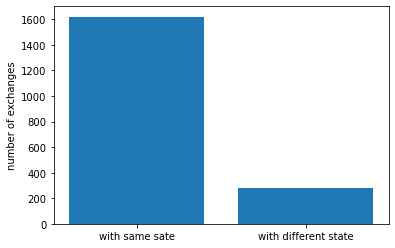

In [33]:
assert mc_stride == 1
diff_sw = diff[is_swapped].sum()
plt.bar(
    ["with same sate", "with different state"], [is_swapped.sum()-diff_sw, diff_sw]
)
plt.ylabel("number of exchanges")

# print('Tot exchanges with lowest prob state:', (state_h == 7).sum())
print(f"Fraction of accepted exchanges: {is_swapped.sum()/len(is_swapped):.2%}")
print(f"  of which between different states: {diff_sw/is_swapped.sum():.2%}")
print(f"Fraction of accepted exchanges between different states: {diff_sw/len(is_swapped):.2%}")

In [ ]:
# np.save(f'dw-LREX-N{dim}', data[0,:,0, 0])